In [161]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams

# SKLEARN
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [162]:
# CHARTS

def plot_sales(dataframe, title, ylabel, xlabel, color='red'):
    
    plt.figure(figsize=(15, 5))
    plt.title(title)
    plt.ylabel(ylabel, color='white')
    # format y axis as currency
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.xlabel(xlabel, color='white')

    plt.bar(dataframe.index, dataframe['Total Sales'])
    # plot mean price in 2nd y axis
    plt.twinx()
    plt.ylabel('Mean Price', color='white')
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.plot(dataframe.index, dataframe['Mean Price'], color=color, linewidth=4)
    plt.show()

In [163]:
## OPEN CSV
lots = pd.read_csv('./models/catalogo_das_artes_lots.csv')
print('Lots found:', lots.shape[0])

Lots found: 3346


In [ ]:
## FIX ARTIST COLUMN

# get everything before the first non-alphabetic character
lots['Artist'] = lots['Artist'].str.extract(r'(^[a-zA-Z ]*)')
lots['Artist'] = lots['Artist'].str.strip()

In [164]:
## FIX DIMENSIONS, PRICES AND SOLD COLUMNS

# DIMENSIONS (Width and Height)
lots['Width'] = lots['Dimensão'].str.extract(r'(.*?) x')
lots['Width'] = lots['Width'].str.replace(' cm', '').str.replace(',', '.').astype(float)
lots['Height'] = lots['Dimensão'].str.extract(r'x (.*) cm')
lots['Height'] = lots['Height'].str.replace(' cm', '').str.replace(',', '.').astype(float)

# PRICES (BRL and USD)
lots['Price_BRL'] = lots['Avaliação'].str.extract(r'R\$ (.*?) \|')
lots['Price_BRL'] = lots['Price_BRL'].str.replace('.', '').str.replace(',', '').astype(float) / 100
lots['Price_USD'] = lots['Avaliação'].str.extract(r'USD (.*)$')
lots['Price_USD'] = lots['Price_USD'].str.replace('.', '').str.replace(',', '').astype(float) / 100

# LOT SOLD
# Sold is True if Avaliação column contains 'Valor de venda em leilão:'
lots['Sold'] = lots['Avaliação'].str.contains('Valor de venda em leilão:')

# YEAR OF SALE (From 'Data da Pesquisa' column)
lots['Year of sale'] = lots['Data da Pesquisa'].str.extract(r'(\d{4})')

KeyError: 'Dimensão'

In [166]:
## SELECT AND TRANSLATE COLUMNS
lots = lots[['Artista', 'Técnica', 'Ano', 'Tipo',
             'Width', 'Height', 'Year of sale', 'Price_BRL', 'img_url', 'url', 'Sold']]

## translate all columns to english
lots = lots.rename(columns={'Artista': 'Artist', 'Técnica': 'Technique', 'Ano': 'Year',
                            'Tipo': 'Type', 'Width': 'Width (cm)', 'Height': 'Height (cm)',
                            'Year of sale': 'Year of sale', 'Price_BRL': 'Price (BRL)'})

KeyError: "['Artista', 'Técnica', 'Ano', 'Tipo', 'Width', 'Height', 'Price_BRL'] not in index"

In [167]:
## DROP ROWS

# ERROR
# lots = lots[lots['Error'] == 'False']

# PRICE = 0
lots = lots[lots['Price (BRL)'] > 0]

# REMOVE DUPLICATES
lots = pd.concat([lots[lots['url'].isna()], lots.drop_duplicates(subset=['url'])])

# RESET INDEX
lots = lots.reset_index(drop=True)

print('Lots: ', len(lots))

Lots:  1770


In [168]:
## FIX TECHNIQUE COLUMN

technique_fix = {'pintura': ['pintad', 'pintura', 'óleo', 'vinil', 'acrílic', 'aquarela', 'guache', 'pastel', 'tinta', 'têmpera'],
                'desenho': ['desenho', 'caneta', 'lápis', 'lapis', 'carvao', 'carvão', 'grafite', 'nanquim', 'giz'],
                'reprodução': ['fine art', 'impressão gráfica', 'reprodução gráfica', 'reprodução', 'giclée', 'giclê', 'gliccée', 'glicée', 'serifrafia', 'litografia', 'litogravura', 'lito offset', 'xilogravura', 'gravura', 'gravu', 'serigrafia', 'xilogravura', 'print', 'agua-forte', 'água-forte']}


def map_technique(technique):
    for key, values in technique_fix.items():
        for value in values:
            if value.lower() in technique.lower():
                return key
    return 'outro'

# technique as string
lots['Technique'] = lots['Technique'].astype(str)

# Criar a nova coluna 'Technique_fix'
lots['Technique_fix'] = lots['Technique'].apply(map_technique)
other_technique_lots = lots[lots['Technique_fix'] == 'outro']
print("Lots with 'other' technique: ", other_technique_lots.shape[0], '(', round(other_technique_lots.shape[0] / lots.shape[0] * 100, 2), '%)')

Lots with 'other' technique:  167 ( 9.44 %)


In [169]:
# SOLD LOTS
sold_lots = lots[lots['Sold'] == True]
print('Sold lots: ', len(sold_lots))

Sold lots:  486


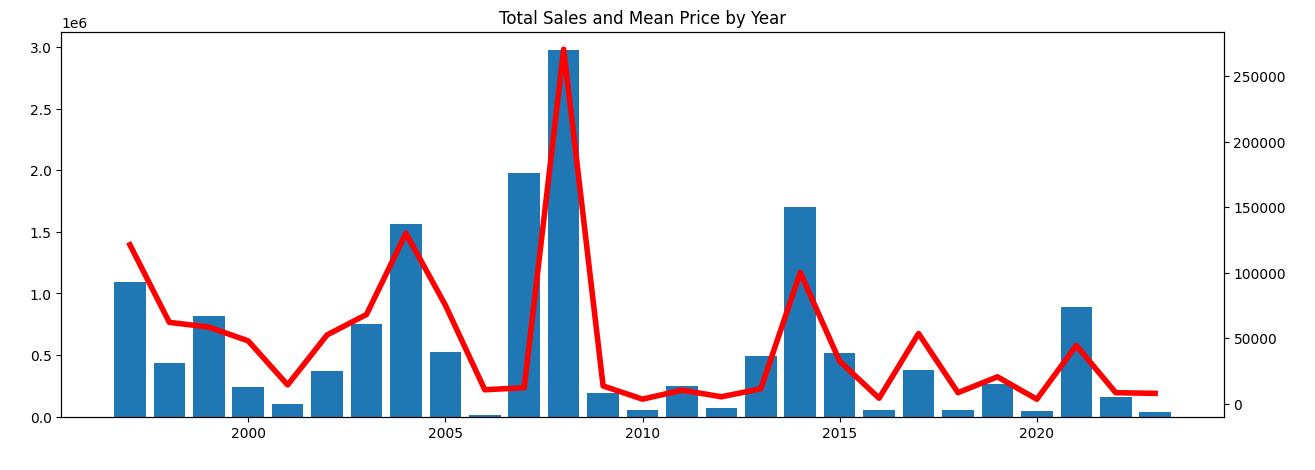

In [170]:
# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
sales = pd.DataFrame(sold_lots.groupby('Year of sale')['Price (BRL)'].sum())
sales['Total Sales'] = sold_lots.groupby('Year of sale')['Price (BRL)'].sum()
sales['Mean Price'] = sold_lots.groupby('Year of sale')['Price (BRL)'].mean()

plot_sales(sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [171]:
# TOP ARTISTS BY SALES COUNT
print('top artists by sales:')
print(sold_lots['Artist'].value_counts().head(5))

print('')

# TOP ARTISTS BY SALES VALUE
print('top artists by sales value:')
print(sold_lots.groupby('Artist')['Price (BRL)'].sum().sort_values(ascending=False).head(5))

top artists by sales:
Artist
Victor Vasarely      124
Candido Portinari    100
Marc Chagall          44
Di Cavalcanti         16
Ant                   15
Name: count, dtype: int64

top artists by sales value:
Artist
Candido Portinari    7606861.0
Di Cavalcanti        2343950.0
Victor Vasarely      1304890.0
Ant                   641990.0
Aldo Bonadei          327250.0
Name: Price (BRL), dtype: float64


In [172]:
## ARTISTS DATAFRAMES

artists = sold_lots.groupby('Artist').apply(lambda x: x.sort_values('Price (BRL)', ascending=False)).reset_index(drop=True).groupby('Artist')

artists_dataframes = {}
for artist in artists:
    artist_name = artist[0]
    artist_df = artist[1]
    artists_dataframes[artist_name] = artist_df

Found 124 lots for Victor Vasarely


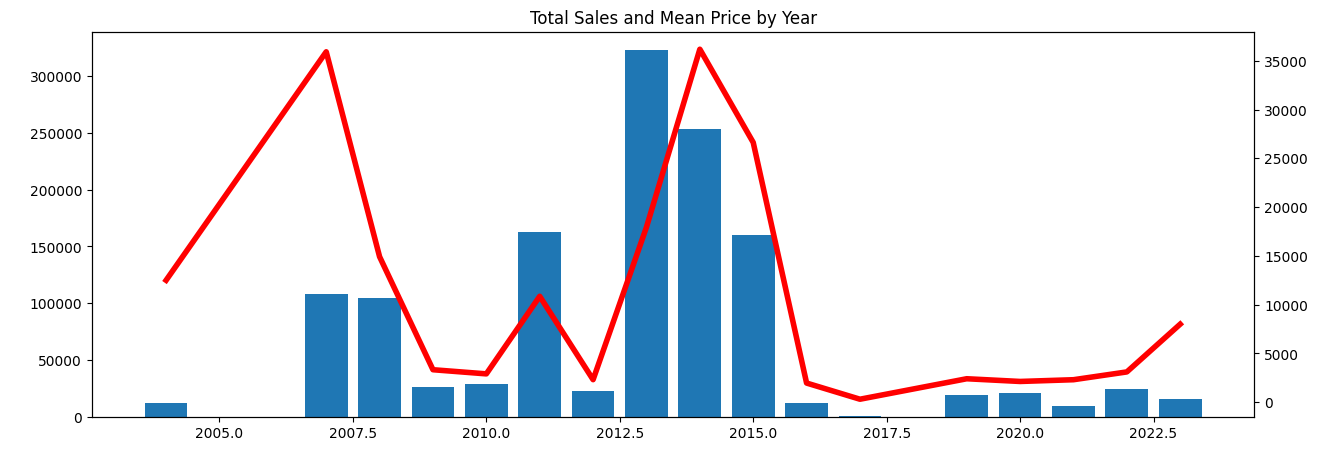

In [173]:
artist_name = 'Victor Vasarely'
artist_df = artists_dataframes[artist_name]

# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
artist_sales = pd.DataFrame(artist_df.groupby('Year of sale')['Price (BRL)'].sum())
artist_sales['Total Sales'] = artist_df.groupby('Year of sale')['Price (BRL)'].sum()
artist_sales['Mean Price'] = artist_df.groupby('Year of sale')['Price (BRL)'].mean()

print(f'Found {artist_df.shape[0]} lots for {artist_name}')
plot_sales(artist_sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [174]:
## FIT PRICE MODELS

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

lots_to_model = lots[['Artist', 'Width (cm)', 'Height (cm)', 'Year of sale', 'Price (BRL)', 'Technique_fix']].dropna()

print(lots_to_model.shape)

X = lots_to_model.drop(['Price (BRL)'], axis=1)
y = lots_to_model['Price (BRL)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = pd.get_dummies(X_train, columns=['Artist', 'Technique_fix'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Artist', 'Technique_fix'], drop_first=True)

# add to X_test all columns that are in X_train but not in X_test
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0

# remove from x_test all columns that are in X_test but not in X_train
for column in X_test.columns:
    if column not in X_train.columns:
        X_test.drop(column, axis=1, inplace=True)

# sort columns alphabetically
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

# function that fits all models and put metrics into a dataframe
# the function returns the dataframe and a dictionary with the models
def fit_models(X_train, y_train, X_test, y_test):
    models = {'Linear Regression': LinearRegression(),
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(),
              'Gradient Boosting': GradientBoostingRegressor()}

    models_df = pd.DataFrame(columns=['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
                             index=['R2', 'RMSE', 'MAE'])

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        r2 = r2_score(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        
        models_df[name] = [r2, rmse, mae]

    return models_df, models

models_df, models = fit_models(X_train, y_train, X_test, y_test)

models_df

(1746, 6)


,Linear Regression,Decision Tree,Random Forest,Gradient Boosting
R2,-0.242878,0.245911,0.040016,0.160722
RMSE,92784.862290,72272.687714,81544.518802,76245.781056
MAE,58301.077257,20237.478053,22695.605901,28284.374610


In [175]:
## SAVE LOCALLY MODEL AND X_TEST

# # save rf model to models
# rf_model = models['Random Forest']
# # save as pkl
# import pickle
# with open('./models/catalogo_rf_model.pkl', 'wb') as file:
#     pickle.dump(rf_model, file)

# # save X_test as csv
# X_test.to_csv('./models/catalogo_X_test.csv', index=False)


In [176]:
## MERGE LOTS DF WITH CATALOGO_DAS_ARTES_LOTS.CSV

# # merge lots df with catalogo_das_artes_lots.csv
# new_lots = pd.read_csv('./temporary-files/catalogo_das_artes_artworks_info.csv')

# # # bring 2 dfs together keeping all columns from both
# merged_lots = pd.concat([lots, new_lots], ignore_index=True)

# merged_lots.shape
# merged_lots.to_csv('./models/catalogo_das_artes_lots.csv', index=False)

In [177]:
lots[lots['url'] == 'NaN']

,Artist,Technique,Year,Type,Width (cm),Height (cm),Year of sale,Price (BRL),img_url,url,Sold,Technique_fix
